In [1]:
import csv
from typing import Final
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from scipy.spatial.distance import directed_hausdorff, cdist

from common import mst_csv_path, vertices_csv_path, Edge, Vertex, centers_csv_path


MCDONALDS: Final[str] = "mcdonalds"
HOUSING: Final[str] = "housing"


def plot_mst(dataset: str):
    vertices = pd.read_csv(vertices_csv_path(dataset), names=["lat", "lon"])
    mst_edges = pd.read_csv(
        mst_csv_path(dataset), names=["p1x", "p1y", "p2x", "p2y", "w"]
    )

    ax = sns.scatterplot(data=vertices, x="lat", y="lon", s=1)
    for _, row in mst_edges.iterrows():
        ax.plot((row["p1x"], row["p2x"]), (row["p1y"], row["p2y"]), linewidth=0.5)


# plot_mst("mcdonalds")
# plot_mst("housing")

<Axes: xlabel='lat', ylabel='lon'>

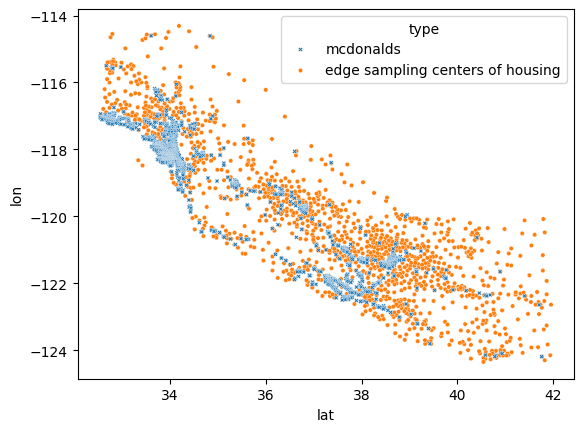

In [2]:
def parse_edge(row: tuple) -> Edge:
    p1x, p1y, p2x, p2y, w = map(float, row)
    return (((p1x, p1y), (p2x, p2y)), w)


def get_mst(dataset: str) -> list[Edge]:
    path = mst_csv_path(dataset)
    with open(path, newline="") as file:
        reader = csv.reader(file)
        return list(map(parse_edge, reader))


def parse_vertex(row: tuple) -> Vertex:
    x, y = map(float, row)
    return (x, y)


def get_vertices(dataset: str) -> list[Vertex]:
    path = vertices_csv_path(dataset)
    with open(path, newline="") as file:
        reader = csv.reader(file)
        return list(map(parse_vertex, reader))


def mst_to_clusters(dataset: str, k: int) -> list[list[Vertex]]:
    edges = get_mst(dataset)
    edges = sorted(edges, key=lambda e: e[1], reverse=True)
    edges = edges[k - 1 :]

    vertices = get_vertices(dataset)

    adj = {v: [] for v in vertices}
    for edge in edges:
        adj[edge[0][0]].append(edge[0][1])
        adj[edge[0][1]].append(edge[0][0])

    visited = set()

    def dfs(v: Vertex, component: list[Vertex]):
        visited.add(v)
        component.append(v)

        for n in adj[v]:
            if n not in visited:
                dfs(n, component)

    components = []

    for v in adj:
        if v not in visited:
            component = []
            dfs(v, component)
            components.append(component)

    return components


def find_centers(components: list[list[Vertex]]) -> list[Vertex]:
    def mean(cluster: list[Vertex]) -> Vertex:
        a = np.array(cluster)
        x, y = np.mean(a, axis=0)
        return (x, y)

    return list(map(mean, components))


def plot_clusters(clusters: list[list[Vertex]]):
    clusters = ((x, y, str(i)) for i, c in enumerate(clusters) for x, y in c)
    df = pd.DataFrame.from_records(clusters, columns=["lat", "lon", "cluster"])
    sns.scatterplot(data=df, x="lat", y="lon", hue="cluster", legend=False, s=10)


def plot_centers(centers: list[Vertex]):
    df = pd.DataFrame.from_records(centers, columns=["lat", "lon"])
    sns.scatterplot(data=df, x="lat", y="lon", s=10)


clusters = mst_to_clusters("housing", 1288)
centers = find_centers(clusters)
centers = pd.DataFrame.from_records(centers, columns=["lat", "lon"])
centers["type"] = "edge sampling centers of housing"
mac_v = pd.read_csv(vertices_csv_path("mcdonalds"), names=["lat", "lon"])
mac_v["type"] = "mcdonalds"
all = pd.concat([centers, mac_v])
sns.scatterplot(
    data=all,
    x="lat",
    y="lon",
    hue="type",
    hue_order=["mcdonalds", "edge sampling centers of housing"],
    style="type",
    s=10,
)

In [118]:
circles = pd.read_csv(vertices_csv_path("circles-500"), names=["lat", "lon"])
circles["type"] = "all"
sns.scatterplot(
    data=circles,
    x="lat",
    y="lon",
    style="type",
    s=10,
)

circles = pd.read_csv(centers_csv_path("circles-500"), names=["lat", "lon"])
circles["type"] = "centers"
sns.scatterplot(
    data=circles,
    x="lat",
    y="lon",
    style="type",
    s=15,
)

FileNotFoundError: [Errno 2] No such file or directory: 'data/circles-500/v.csv'

<Axes: xlabel='lat', ylabel='lon'>

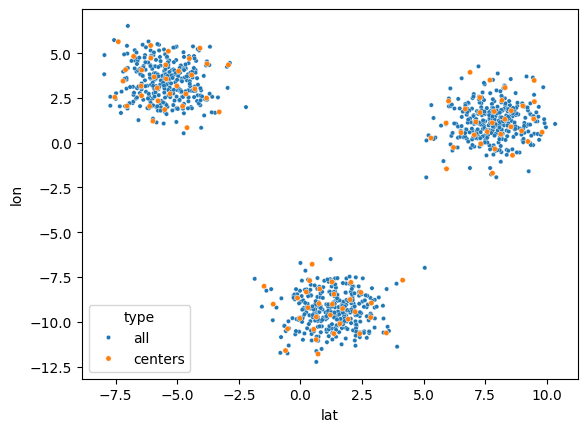

In [ ]:
blobs = pd.read_csv(vertices_csv_path("blobs-1000"), names=["lat", "lon"])
blobs["type"] = "all"
sns.scatterplot(
    data=blobs,
    x="lat",
    y="lon",
    style="type",
    s=10,
)
blobs = pd.read_csv(centers_csv_path("blobs-1000"), names=["lat", "lon"])
blobs["type"] = "centers"
sns.scatterplot(
    data=blobs,
    x="lat",
    y="lon",
    style="type",
    s=15,
)

<Axes: xlabel='lat', ylabel='lon'>

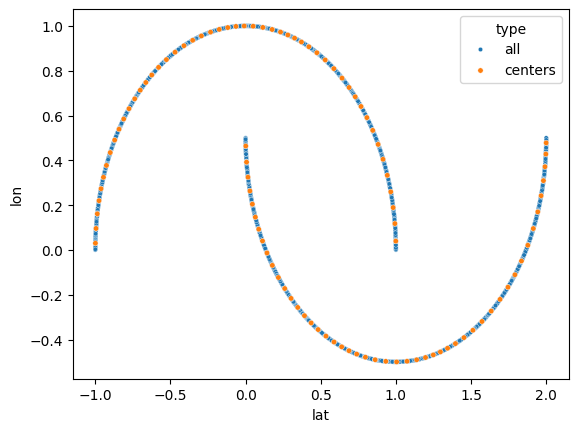

In [ ]:
moons = pd.read_csv(vertices_csv_path("moons-2000"), names=["lat", "lon"])
moons["type"] = "all"
sns.scatterplot(
    data=moons,
    x="lat",
    y="lon",
    style="type",
    s=10,
)

moons = pd.read_csv(centers_csv_path("moons-2000"), names=["lat", "lon"])
moons["type"] = "centers"
sns.scatterplot(
    data=moons,
    x="lat",
    y="lon",
    style="type",
    s=15,
)

In [ ]:
mac = get_vertices(MCDONALDS)
mac = np.array(mac)

clusters = mst_to_clusters(HOUSING, len(mac))
centers = find_centers(clusters)
centers = np.array(centers)

print(directed_hausdorff(mac, centers), directed_hausdorff(centers, mac))

(0.34138699515137605, 635, 418) (1.4910702569013972, 573, 823)


6295761.551405125
(0.15090753056425488, 846, 587) (1.4910702569013972, 59, 823)


<Axes: xlabel='lat', ylabel='lon'>

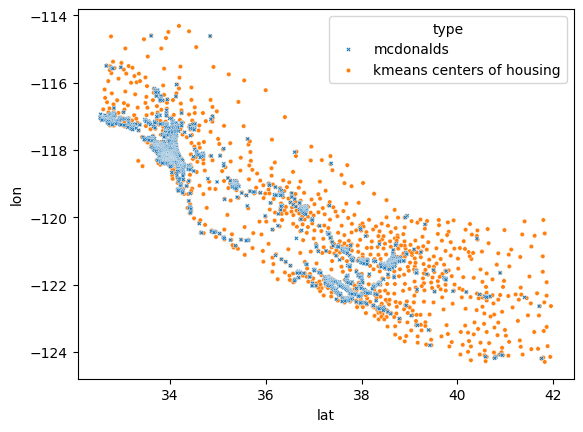

In [131]:
mac = pd.read_csv(vertices_csv_path(MCDONALDS), names=["lat", "lon"])
mac_np = mac.to_numpy()
mac["type"] = "mcdonalds"
centers = pd.read_csv(centers_csv_path(HOUSING), names=["lat", "lon"])
centers_np = centers.to_numpy()
centers["type"] = "kmeans centers of housing"
all = pd.concat([centers, mac])
print(cdist(mac_np, centers_np).sum())
print(directed_hausdorff(mac_np, centers_np), directed_hausdorff(centers_np, mac_np))
sns.scatterplot(
    data=all,
    x="lat",
    y="lon",
    hue="type",
    hue_order=["mcdonalds", "kmeans centers of housing"],
    style="type",
    s=10,
)

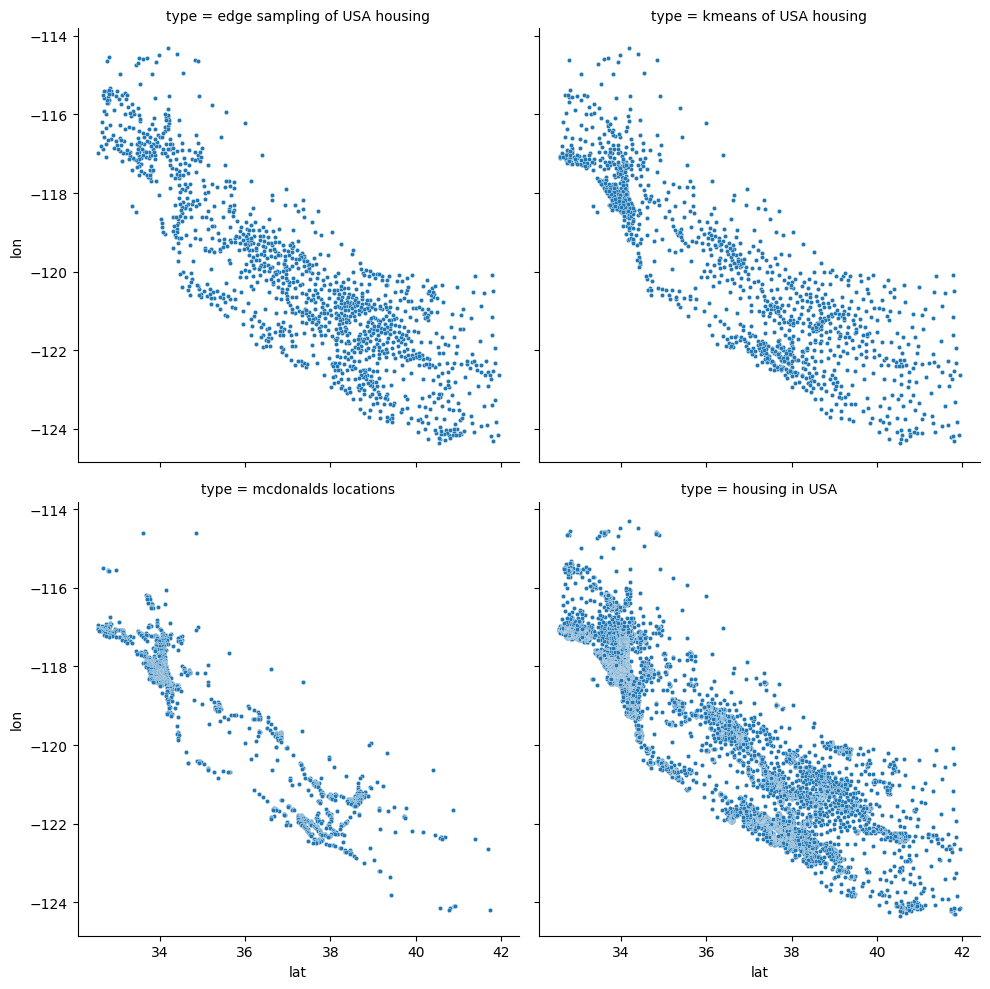

In [ ]:
clusters = mst_to_clusters(HOUSING, 1288)
centers_mst = find_centers(clusters)
centers_mst = pd.DataFrame.from_records(centers_mst, columns=["lat", "lon"])
centers_mst["type"] = "edge sampling of USA housing"

centers_kmeans = pd.read_csv(centers_csv_path("housing-full"), names=["lat", "lon"])
centers_kmeans["type"] = "kmeans of USA housing"

mac = pd.read_csv(vertices_csv_path(MCDONALDS), names=["lat", "lon"])
mac["type"] = "mcdonalds locations"

housing = pd.read_csv(vertices_csv_path(HOUSING), names=["lat", "lon"])
housing["type"] = "housing in USA"

all = pd.concat([centers_mst, centers_kmeans, mac, housing])

sns.relplot(data=all, x="lat", y="lon", col="type", col_wrap=2, s=10)

In [3]:
def load_df(dataset: str):
    return pd.read_csv(dataset, names=["lat", "lon"])


def load_np(dataset: str):
    return np.loadtxt(dataset, np.float64, delimiter=",")


def clean_scatter(data: pd.DataFrame, *, s: int = 2):
    p = sns.relplot(data=data, x="lat", y="lon", s=s, edgecolors="none")
    p.set(xticklabels=[], xlabel=None, yticklabels=[], ylabel=None)
    p.tick_params(bottom=False, left=False)
    p.ax.axis("off")
    return p

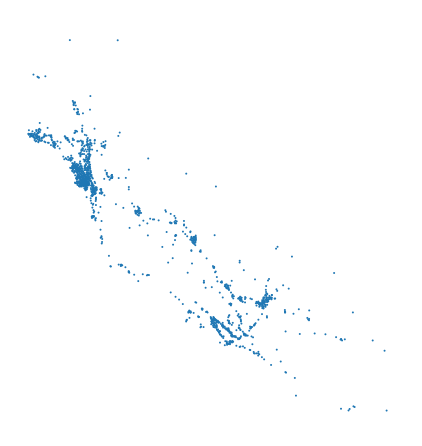

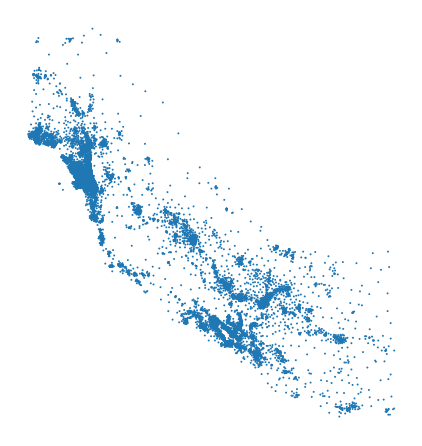

In [4]:
mcdonalds = load_df(vertices_csv_path(MCDONALDS))
mcdonalds = clean_scatter(mcdonalds)
k_x_lim_1, k_x_lim_2 = mcdonalds.ax.get_xlim()
k_y_lim_1, k_y_lim_2 = mcdonalds.ax.get_ylim()

housing_full = load_df(vertices_csv_path("housing-full"))
housing_full = clean_scatter(housing_full)#.savefig("img/housing.pdf")
h_x_lim_1, h_x_lim_2 = housing_full.ax.get_xlim()
h_y_lim_1, h_y_lim_2 = housing_full.ax.get_ylim()

res_x_lim_1 = min(k_x_lim_1, h_x_lim_1)
res_x_lim_2 = max(k_x_lim_2, h_x_lim_2)

res_y_lim_1 = min(k_y_lim_1, h_y_lim_1)
res_y_lim_2 = max(k_y_lim_2, h_y_lim_2)

mcdonalds.ax.set_xlim((res_x_lim_1, res_x_lim_2))
mcdonalds.ax.set_ylim((res_y_lim_1, res_y_lim_2))

housing_full.ax.set_xlim((res_x_lim_1, res_x_lim_2))
housing_full.ax.set_ylim((res_y_lim_1, res_y_lim_2))

mcdonalds.savefig("img/mac.pdf")
housing_full.savefig("img/housing.pdf")

In [ ]:
seed = 103583456


def blobs(n: int):
    points, _ = sklearn.datasets.make_blobs(n, random_state=seed)
    return pd.DataFrame(points, columns=["lat", "lon"])


def circles(n: int):
    points, _ = sklearn.datasets.make_circles(n, noise=0.035, random_state=seed)
    return pd.DataFrame(points, columns=["lat", "lon"])


def moons(n: int):
    points, _ = sklearn.datasets.make_moons(n, noise=0.035, random_state=seed)
    return pd.DataFrame(points, columns=["lat", "lon"])


for f in [blobs, circles, moons]:
    data = f(500)
    clean_scatter(data, s=10).savefig(f"img/{f.__name__}-1000.pdf")

In [5]:
mcdonalds = load_np(vertices_csv_path(MCDONALDS))
kmeans = load_np(centers_csv_path("housing-full"))

mst = mst_to_clusters(HOUSING, 1288)
mst = find_centers(clusters)
mst = np.array(mst)

print(cdist(mcdonalds, kmeans, "euclidean").sum())
print(cdist(mcdonalds, mst, "euclidean").sum())
print(cdist(mcdonalds, mcdonalds, "euclidean").sum())

6217185.058621562
6700068.821430479
5311272.456728991


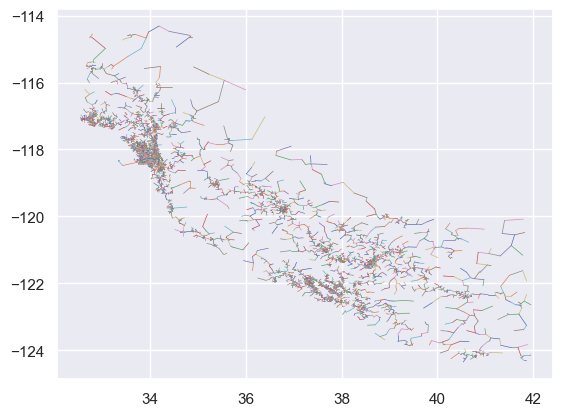

In [270]:
housing = load_df(vertices_csv_path(HOUSING))
edges = pd.read_csv(mst_csv_path(HOUSING), names=["p1x", "p1y", "p2x", "p2y", "w"])
p, ax = plt.subplots()
for _, row in edges.iterrows():
    ax.plot((row["p1x"], row["p2x"]), (row["p1y"], row["p2y"]), linewidth=0.5)

# p.savefig("img/housing-mst.pdf")

In [3]:
for n in [500, 1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000]:
    for generate in [blobs, circles, moons]:
        data = generate(n)
        dir = Path("data", f"{generate.__name__}-{n}")
        dir.mkdir(parents=True, exist_ok=True)
        data.to_csv(dir / "v.csv", header=False, index=False)


NameError: name 'blobs' is not defined

614.9457599131291


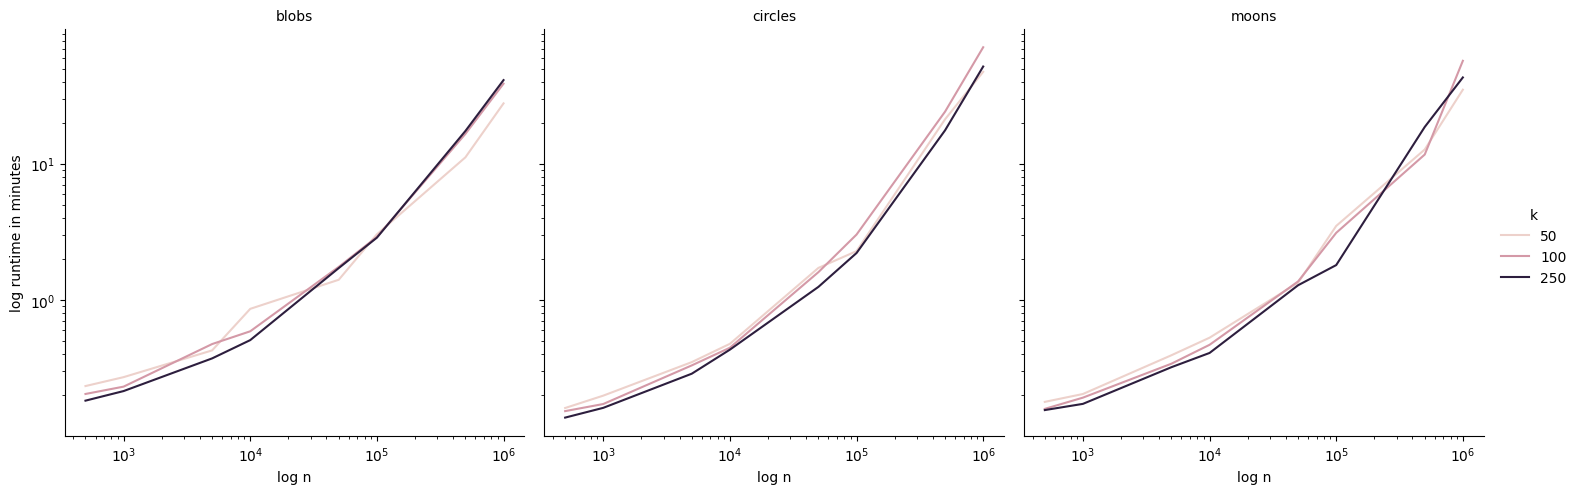

In [5]:
stats = pd.read_csv("data/stats.csv")
stats = stats.groupby(["dataset", "n", "k"]).mean()
# stats["k"] = stats["k"].apply(str)
stats["runtime"] = stats["runtime"] / 60_000_000_000
print(stats["runtime"].sum())
ax = sns.relplot(data=stats, kind="line", x="n", y="runtime", hue="k", col="dataset")
ax.set_axis_labels("log n", "log runtime in minutes").set_titles("{col_name}")
# ax.set_xticklabels([500, 1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000])
plt.xscale("log")
plt.yscale("log")
ax.savefig("img/runtime.pdf")

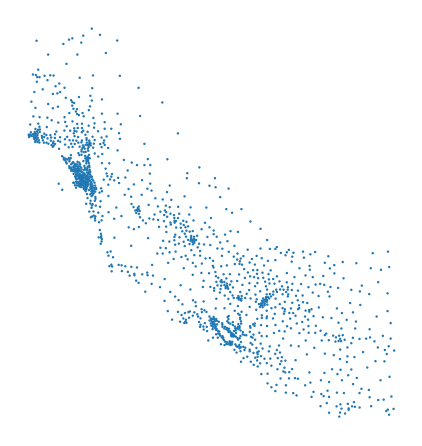

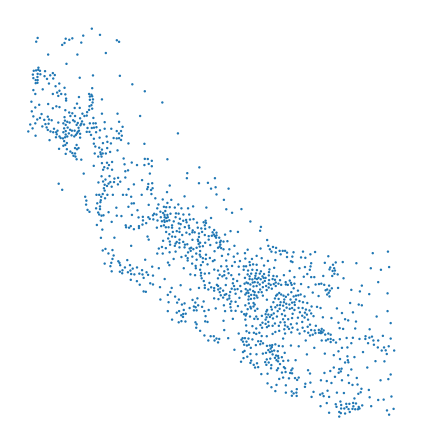

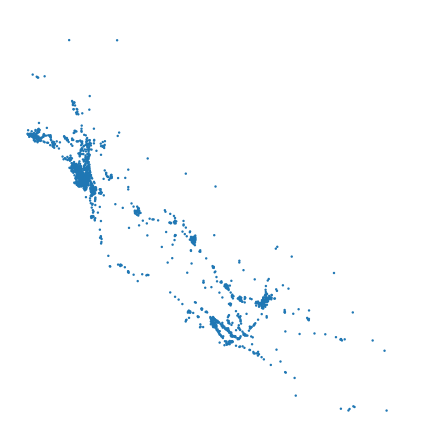

In [262]:
s = 3

k_means = load_df(centers_csv_path("housing-full"))
k_means = clean_scatter(k_means, s=s) #.savefig("img/k-means.pdf")
k_x_lim_1, k_x_lim_2 = k_means.ax.get_xlim()
k_y_lim_1, k_y_lim_2 = k_means.ax.get_ylim()

mst = mst_to_clusters(HOUSING, 1288)
mst = find_centers(mst)
mst = pd.DataFrame.from_records(mst, columns=["lat", "lon"])
mst = clean_scatter(mst, s=s)#.savefig("img/mst.pdf")
mst_x_lim_1, mst_x_lim_2 = mst.ax.get_xlim()
mst_y_lim_1, mst_y_lim_2 = mst.ax.get_ylim()


res_x_lim_1 = min(k_x_lim_1, mst_x_lim_1)
res_x_lim_2 = max(k_x_lim_2, mst_x_lim_2)

res_y_lim_1 = min(k_y_lim_1, mst_y_lim_1)
res_y_lim_2 = max(k_y_lim_2, mst_y_lim_2)

k_means.ax.set_xlim((res_x_lim_1, res_x_lim_2))
k_means.ax.set_ylim((res_y_lim_1, res_y_lim_2))

mst.ax.set_xlim((res_x_lim_1, res_x_lim_2))
mst.ax.set_ylim((res_y_lim_1, res_y_lim_2))

mcdonalds = load_df(vertices_csv_path(MCDONALDS))
mcdonalds = clean_scatter(mcdonalds, s=s)
mcdonalds.ax.set_xlim((res_x_lim_1, res_x_lim_2))
mcdonalds.ax.set_ylim((res_y_lim_1, res_y_lim_2))

k_means.savefig("img/k-means.pdf")
mst.savefig("img/mst.pdf")
mcdonalds.savefig("img/mac-cluster.pdf")

